In [2]:
#for testing this code,skip 1a
!pip install pgmpy
!pip install matplotlib==2.2.3

     |████████████████████████████████| 337kB 3.3MB/s 
     |████████████████████████████████| 12.6MB 177kB/s 
ERROR: plotnine 0.5.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


In [0]:
from pgmpy.models import BayesianModel, MarkovModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sklearn.utils
import itertools


from random import randint
import random
import time
from IPython.display import clear_output
import gc


**1a . Data generation**

In [0]:
lst = itertools.product([0],[1],[3],[7],range(16),range(32),range(64))
lstNoise = itertools.product([0],[0],[0,1,2],[0,1,2,3,4,5,6],range(16),range(32),range(64))   

In [0]:
df = pd.DataFrame(lst, columns=['S0','S1','S2','S3','S4','S5','S6'])
dfNoise = pd.DataFrame(lstNoise, columns=['S0','S1','S2','S3','S4','S5','S6'])

In [55]:
print(dfNoise.tail())

        S0  S1  S2  S3  S4  S5  S6
688123   0   0   2   6  15  31  59
688124   0   0   2   6  15  31  60
688125   0   0   2   6  15  31  61
688126   0   0   2   6  15  31  62
688127   0   0   2   6  15  31  63


*Shuffle to data and delete half*

In [80]:
#shuffle data
df = sklearn.utils.shuffle(df)
df.reset_index(drop=True,inplace=True)

dfTrain = df.iloc[0:2**13]
dfTest = df.iloc[2**13+50:2**13+51]
print (dfTest)

#shuffle noise
dfNoise = sklearn.utils.shuffle(dfNoise)
dfNoise.reset_index(drop=True,inplace=True)

dfNoiseTrain = dfNoise.iloc[0:2**14]
dfNoiseTest = dfNoise.iloc[2**14+50:2**14+55]
print(dfNoiseTest)

#add noise
dfTrain = dfTrain.append(dfNoiseTrain,ignore_index=True)
dfTrain = sklearn.utils.shuffle(dfTrain)
dfTrain.reset_index(drop=True,inplace=True)

dfTest = dfTest.append(dfNoiseTest,ignore_index=True)
dfTest = sklearn.utils.shuffle(dfTest)
dfTest.reset_index(drop=True,inplace=True)
print(dfTest)

#save
dfTrain.to_csv('PGM_TrainData.csv')
dfTest.to_csv('PGM_TestData.csv')

'''
#free memory
df = pd.DataFrame()
dfNoise = pd.DataFrame()

dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()

dfNoiseTrain = pd.DataFrame()
dfNoiseTest = pd.DataFrame()

gc.collect()
'''
#clear_output()




      S0  S1  S2  S3  S4  S5  S6
8242   0   1   3   7   9   2   1
       S0  S1  S2  S3  S4  S5  S6
16434   0   0   1   4  10   7  57
16435   0   0   1   0   6   5  62
16436   0   0   1   5   3   5  18
16437   0   0   1   2   6  16  42
16438   0   0   0   5   8  26  51
   S0  S1  S2  S3  S4  S5  S6
0   0   0   1   4  10   7  57
1   0   1   3   7   9   2   1
2   0   0   1   5   3   5  18
3   0   0   1   0   6   5  62
4   0   0   1   2   6  16  42
5   0   0   0   5   8  26  51


'\n#free memory\ndf = pd.DataFrame()\ndfNoise = pd.DataFrame()\n\ndfTrain = pd.DataFrame()\ndfTest = pd.DataFrame()\n\ndfNoiseTrain = pd.DataFrame()\ndfNoiseTest = pd.DataFrame()\n\ngc.collect()\n'

**1b . Data loading**

In [0]:
dfTrain = pd.read_csv('./PGM_TrainData.csv',index_col=0,header=0)
dfTest = pd.read_csv('./PGM_TestData.csv',index_col=0,header=0)

**2 . Data Visualization and Verification**

In [0]:
def plot_graph(numNode,sGraph,figName='save'):
  G = nx.Graph()
  G.add_nodes_from(range(numNode))

  for i in range(4):
    for j in range(i):
      strt = bin(sGraph.iloc[i])[2:].zfill(i)#fixed length binary form conversion with removal of 0b from the start
      if int(strt[j]):
        G.add_edge(i,j,weight=10.0)

  for i in range(4,numNode):
    for j in range(i):
      strt = bin(sGraph.iloc[i])[2:].zfill(i)#fixed length binary form conversion with removal of 0b from the start
      if int(strt[j]):
        G.add_edge(i,j,weight=5.0)

  edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
  nx.draw_circular(G,with_labels=True,edge_color=weights,width=2.0,edge_vmin=0,edge_vmax=10,edge_cmap=plt.cm.Blues)
  plt.savefig(figName+'.png')
  plt.show()


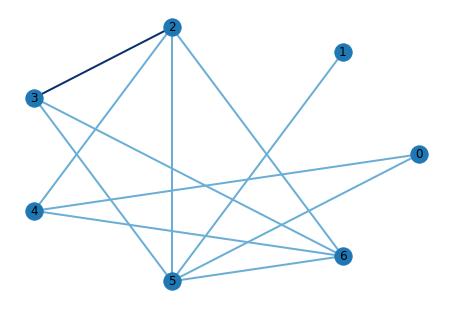

In [83]:
for p in range(50,55):
  clear_output()
  plot_graph(7,dfTrain.iloc[3*p],figName='save'+str(3*p))
  time.sleep(2)


**3 . PGM**

***Representation***

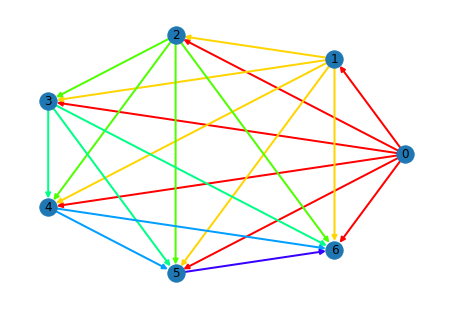

In [84]:
#clear representation of bayesian network
G = nx.DiGraph()
G.add_nodes_from(range(7))
for i in range(7):
    for j in range(i+1,7):
        G.add_edge(i,j,weight=3*(i+1))

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw_circular(G,with_labels=True,edge_color=weights,width=2.0,edge_vmin=3,edge_vmax=24,edge_cmap=plt.get_cmap('hsv'))
plt.savefig('BayesianNetwork.png')
plt.show()

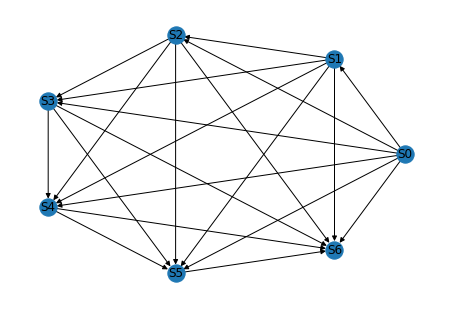

In [85]:
#preparing Bayesian Network using pgmpy
model = BayesianModel([
 ('S0', 'S1'),('S0', 'S2'),('S0', 'S3'),('S0', 'S4'),('S0', 'S5'),('S0', 'S6'),
 ('S1', 'S2'),('S1', 'S3'),('S1', 'S4'),('S1', 'S5'),('S1', 'S6'),
 ('S2', 'S3'),('S2', 'S4'),('S2', 'S5'),('S2', 'S6'),
 ('S3', 'S4'),('S3', 'S5'),('S3', 'S6'),
 ('S4', 'S5'),('S4', 'S6'),
 ('S5', 'S6'),
])
nx.draw_circular(model, with_labels=True)
plt.show()

***Learning(Parameter estimation)***

In [0]:
# Fitting the data to the model using Bayesian Estimator
model.fit(dfTrain, estimator=BayesianEstimator)

In [87]:
model.get_cardinality() #check cardinality

defaultdict(int,
            {'S0': 1, 'S1': 2, 'S2': 4, 'S3': 8, 'S4': 16, 'S5': 32, 'S6': 64})

***Inference***

In [0]:
inference = VariableElimination(model) #running variable elimination

Current Graph:  0  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 41.84it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 42.78it/s]


S1  :  0  :  0.6666327651438102  :  0.6666327651438102


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 67.76it/s]


S2  :  1  :  0.32884539102309834  :  0.21921911232252556


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 113.24it/s]


S3  :  4  :  0.14402155002435688  :  0.03157227635165372


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 112.98it/s]


S4  :  10  :  0.0657213251726429  :  0.002074971840547578


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 192.23it/s]


S5  :  7  :  0.0392149237013919  :  8.136986240960999e-05


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

S6  :  57  :  1.1920019529759997e-06  :  9.69930349056435e-11

Current maxProb: 9.69930349056435e-11 

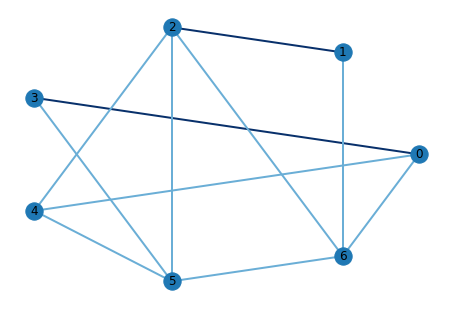

Current Graph:  1  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 42.21it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 41.61it/s]


S1  :  1  :  0.3333672348561899  :  0.3333672348561899


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 67.68it/s]


S2  :  3  :  0.9997711879919459  :  0.33329095642976303


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 119.58it/s]


S3  :  7  :  0.9999332478906333  :  0.3332687085553885


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 109.90it/s]


S4  :  9  :  0.06665035104416804  :  0.02221247641725317


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 336.86it/s]


S5  :  2  :  0.03479850306469761  :  0.0007729609286803078


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

S6  :  1  :  1.2548245494276394e-07  :  9.69930349056437e-11

Current maxProb: 9.69930349056437e-11 

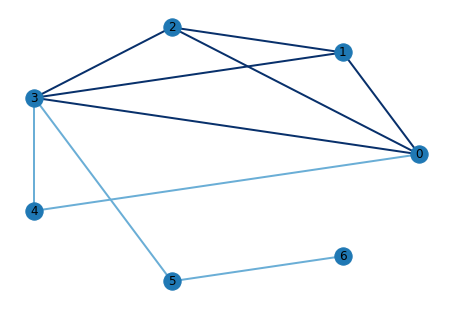

Current Graph:  2  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 43.92it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 43.99it/s]


S1  :  0  :  0.6666327651438102  :  0.6666327651438102


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 64.56it/s]


S2  :  1  :  0.32884539102309834  :  0.21921911232252556


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 121.01it/s]


S3  :  5  :  0.14903210466491917  :  0.0326706856922013


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 127.78it/s]


S4  :  3  :  0.06849256765959102  :  0.00223769915025833


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 184.28it/s]


S5  :  5  :  0.03636318242343538  :  8.136986240960999e-05


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

S6  :  18  :  1.1920019529759997e-06  :  9.69930349056435e-11

Current maxProb: 9.69930349056437e-11 

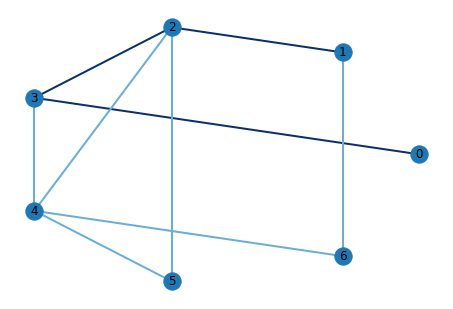

Current Graph:  3  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 42.53it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]


S1  :  0  :  0.6666327651438102  :  0.6666327651438102


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 73.44it/s]


S2  :  1  :  0.32884539102309834  :  0.21921911232252556


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 100.49it/s]


S3  :  0  :  0.1395677236771904  :  0.03059591249338921


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 103.93it/s]


S4  :  6  :  0.07712614007022207  :  0.002359744632541394


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 192.80it/s]


S5  :  5  :  2.630604239271345e-06  :  6.207554233961193e-09


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


S6  :  62  :  0.015625  :  9.699303490564364e-11

Current maxProb: 9.69930349056437e-11 

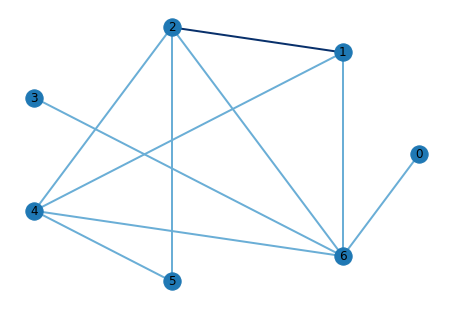

Current Graph:  4  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 13.94it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 40.58it/s]


S1  :  0  :  0.6666327651438102  :  0.6666327651438102


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 71.15it/s]


S2  :  1  :  0.32884539102309834  :  0.21921911232252556


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 123.26it/s]


S3  :  2  :  0.14253694124196803  :  0.031246821732232213


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 119.54it/s]


S4  :  6  :  0.06249999999999999  :  0.0019529263582645131


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 306.58it/s]


S5  :  16  :  0.041665607136318276  :  8.136986240960997e-05


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

S6  :  42  :  1.1920019529759997e-06  :  9.699303490564346e-11

Current maxProb: 9.69930349056437e-11 

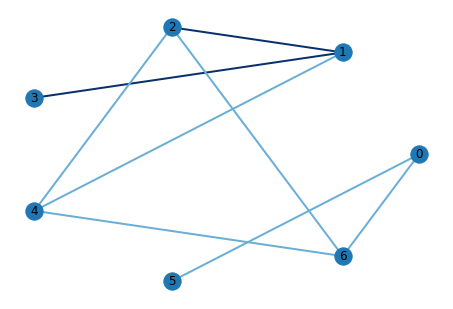

Current Graph:  5  : Checking similarity strength to data


Eliminating: S1: 100%|██████████| 6/6 [00:00<00:00, 40.70it/s]


S0  :  0  :  1.0  :  1.0


Eliminating: S4: 100%|██████████| 5/5 [00:00<00:00, 44.43it/s]


S1  :  0  :  0.6666327651438102  :  0.6666327651438102


Eliminating: S5: 100%|██████████| 4/4 [00:00<00:00, 68.95it/s]


S2  :  0  :  0.3343987428676044  :  0.2229211586184451


Eliminating: S5: 100%|██████████| 3/3 [00:00<00:00, 119.12it/s]


S3  :  5  :  0.14418470698268587  :  0.03214182193564135


Eliminating: S5: 100%|██████████| 2/2 [00:00<00:00, 109.52it/s]


S4  :  8  :  0.053165480075150796  :  0.001708835393698385


Eliminating: S6: 100%|██████████| 1/1 [00:00<00:00, 151.68it/s]


S5  :  26  :  3.632622695464164e-06  :  6.207554233961193e-09


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


S6  :  51  :  0.015625  :  9.699303490564364e-11

Current maxProb: 9.69930349056437e-11 

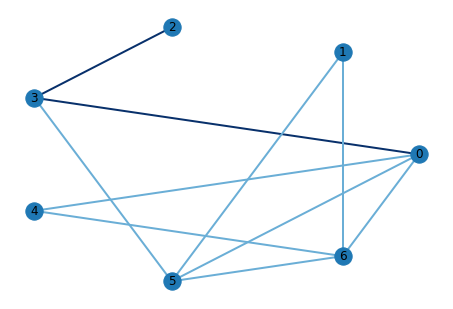

final graph: {'S0': 0, 'S1': 1, 'S2': 3, 'S3': 7, 'S4': 9, 'S5': 2, 'S6': 1}
prediction strength: 9.69930349056437e-11


In [89]:
maxProb=float('-inf')
maxG = {}

print('\rStarting...',end=" ")
time.sleep(1)
for index, row in dfTest.iterrows():
    
    print('\rCurrent Graph: ' ,index, ' :' ,'Checking similarity strength to data')
    #create dictory for graph to pass as evidence
    d = {'S0': row.iloc[0],
         'S1': row.iloc[1],
         'S2': row.iloc[2], 
         'S3': row.iloc[3],
         'S4': row.iloc[4],
         'S5': row.iloc[5],
         'S6': row.iloc[6]}
    

    #calculate joint probability of BN based on graph
    prob = 1 #reintailize
    for i in range(7):
      node = 'S'+str(i)
      q = inference.query(variables=[node], evidence=dict(list(d.items())[:i]))#P(Si|S0,S1..Si)
      prob *=  q.values[d[node]] #P(S0)*P(S1|S0)*P(S2|S0,S1)*P(S3|S0,S1,S2)*...*P(S7|S0,S1...,S6)
      print(node,' : ',d[node],' : ',q.values[d[node]],' : ',prob)

    #if maximum probabilty value and repective graph 
    if prob > maxProb:
      maxProb = prob
      maxG = d
    
    print('\nCurrent maxProb:', maxProb,end=" ")#leading graph and probability value
    plot_graph(7,pd.Series(d),figName='final '+str(index)+'('+str(prob)+')')#vizualization of final graph
    time.sleep(3)


print('final graph:',maxG)#final graph #graph with most similarity
print('prediction strength:',maxProb)#final value #prediction strength

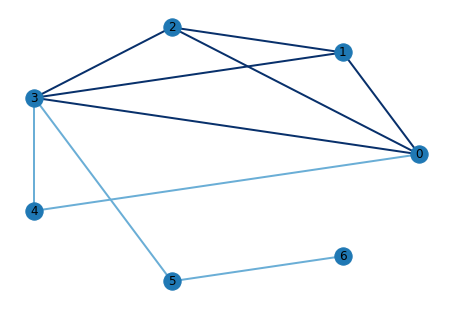

In [90]:
plot_graph(7,pd.Series(maxG),figName='output('+str(prob)+')')#vizualization of final graph